# Homework 5 - Data Analysis Option

## Cancer Image Classification (Benign and Malignant)

In [336]:
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
import os

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.linear_model import RidgeClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm

### Load data

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("obulisainaren/multi-cancer")

print("Path to dataset files:", path)

Path to dataset files: /Users/pattonvogtlab/.cache/kagglehub/datasets/obulisainaren/multi-cancer/versions/3


In [ ]:
# # load an image from a folder
# image = Image.open('Multi Cancer/Breast Cancer/breast_benign/breast_benign_0001.jpg')  

# # convert to a numpy array to get pixel values
# pixels = np.array(image)

# # shape of the image (height, width, color channels)
# print(pixels.shape)

# # get pixel value at a specific position 
# x, y = 100, 150
# pixel_value = pixels[y, x]
# print(f"Pixel value at (100, 150): {pixel_value}")


(512, 512, 3)
Pixel value at (100, 150): [159 158 156]


In [ ]:
# image.show()

### Make training matrix

In [132]:
pixels_data_train = []

# Sort the filenames before processing !!
sorted_files_train = sorted(os.listdir('cancer_train'))

for file_name in sorted_files_train:
    if file_name.lower().endswith('.jpg'):
        # load image
        image_path = os.path.join('cancer_train', file_name)
        image = Image.open(image_path)

        # put image in greyscale (RGB was too complicated)
        image = image.convert('L')

        # Convert image to a np array (height, width)
        pixels = np.array(image)

        # flatten the pixel data (height * width)
        flattened_pixels = pixels.flatten()
        pixels_data_train.append(flattened_pixels)

# Convert the list of flattened pixel data to a np array (training matrix)
Xtrain = np.array(pixels_data_train)

print(f"Training matrix shape: {Xtrain.shape}")


Training matrix shape: (600, 262144)


In [ ]:
# 512*512 = 786432

### Make testing data matrix

In [256]:
pixels_data_test = []

# sort by filename before processing !!
sorted_files_test = sorted(os.listdir('cancer_test'))

for file_name in sorted_files_test:
    if file_name.lower().endswith('.jpg'):
        # load image
        image_path = os.path.join('cancer_test', file_name)
        image = Image.open(image_path)

        # convert image to greyscale (it was not working in RGB)
        image = image.convert('L')

        # Convert image to a np array (height, width) is (512 by 512)
        pixels = np.array(image)

        # flatten pixel data (height * width)
        flattened_pixels = pixels.flatten()
        pixels_data_test.append(flattened_pixels)

# convert list of flattened pixel data to np array (testing matrix)
Xtest = np.array(pixels_data_test)

print(f"Testing matrix shape: {Xtest.shape}")


Testing matrix shape: (150, 262144)


In [258]:
traindata_imgs = Xtrain.reshape((600, 512, 512))   
print(traindata_imgs.shape) 

testdata_imgs =  Xtest.reshape((150,512,512))
print(testdata_imgs.shape)

(600, 512, 512)
(150, 512, 512)


### Plot a few training images

In [259]:
image1 = Image.fromarray(traindata_imgs[0])
# plt.imshow(image1)

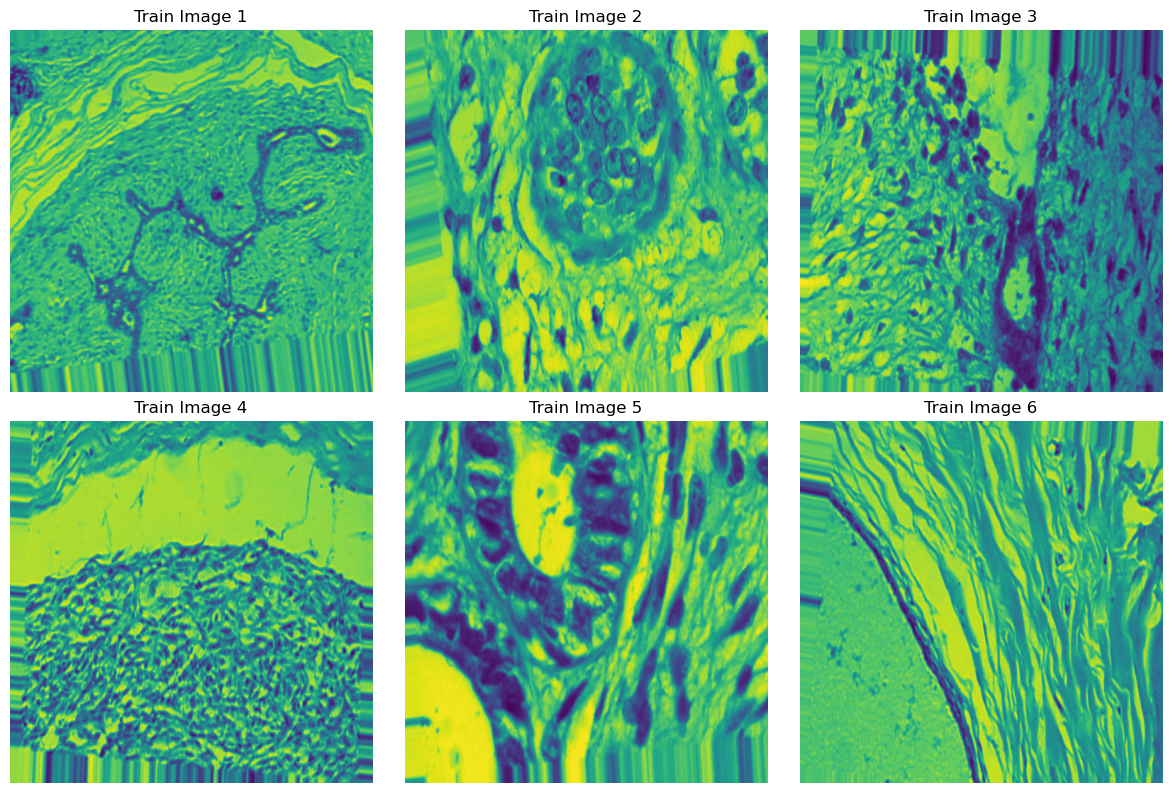

In [260]:
# figure with 2 rows and 3 columns (6 images)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Loop through the images and display them in the grid
for j in range(6):
    imagej = Image.fromarray(traindata_imgs[j])
    
    # Plot each image on the corresponding subplot
    ax = axes[j // 3, j % 3]  # Find the row and column for the subplot
    ax.imshow(imagej)
    ax.axis('off') 
    ax.set_title(f'Train Image {j+1}')  # Optional: Add titles for each image

# Display all the images at once
plt.tight_layout()
plt.show()

### Plot a few testing images

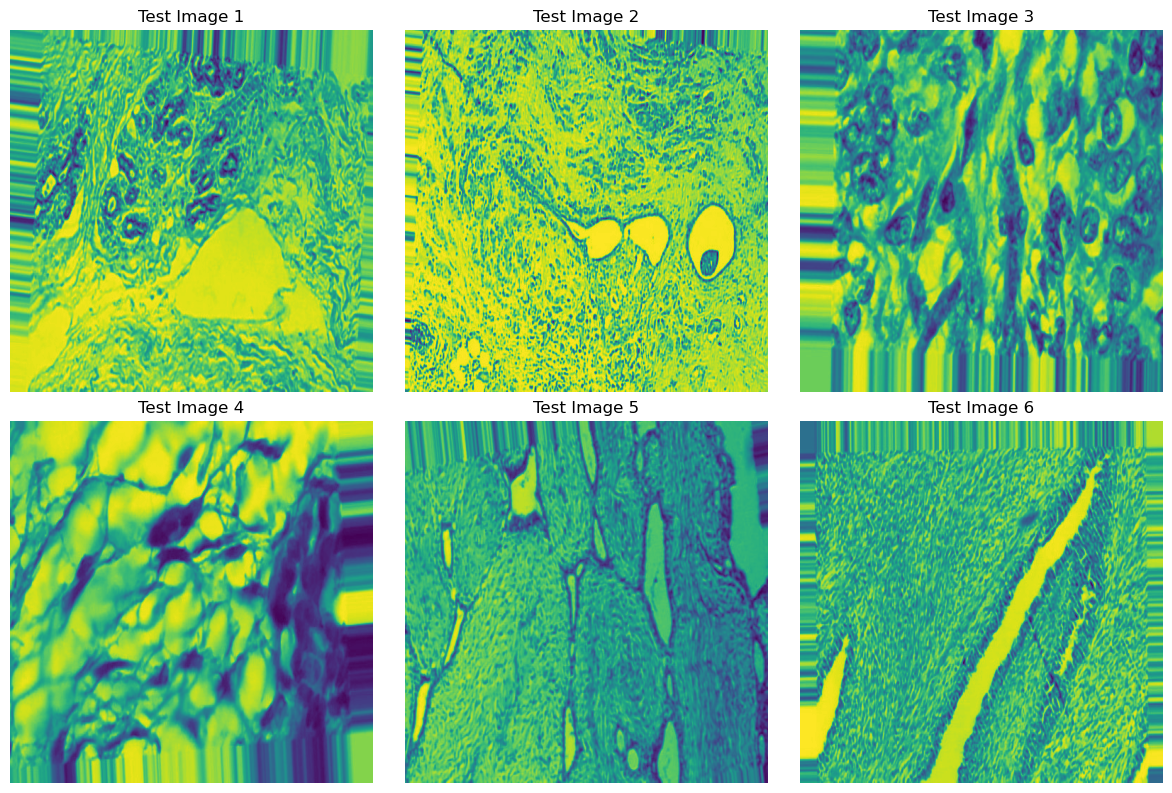

In [261]:
# Create a figure with 2 rows and 3 columns (6 images)
fig2, axes2 = plt.subplots(2, 3, figsize=(12, 8))

for j in range(6):
    imagej = Image.fromarray(testdata_imgs[j])
    
    # Plot each image on the corresponding subplot
    ax2 = axes2[j // 3, j % 3]  # Find the row and column for the subplot
    ax2.imshow(imagej)
    ax2.axis('off')  
    ax2.set_title(f'Test Image {j+1}') 

# show all  images at once
plt.tight_layout()
plt.show()

#### Another way of plotting images - from HW 3

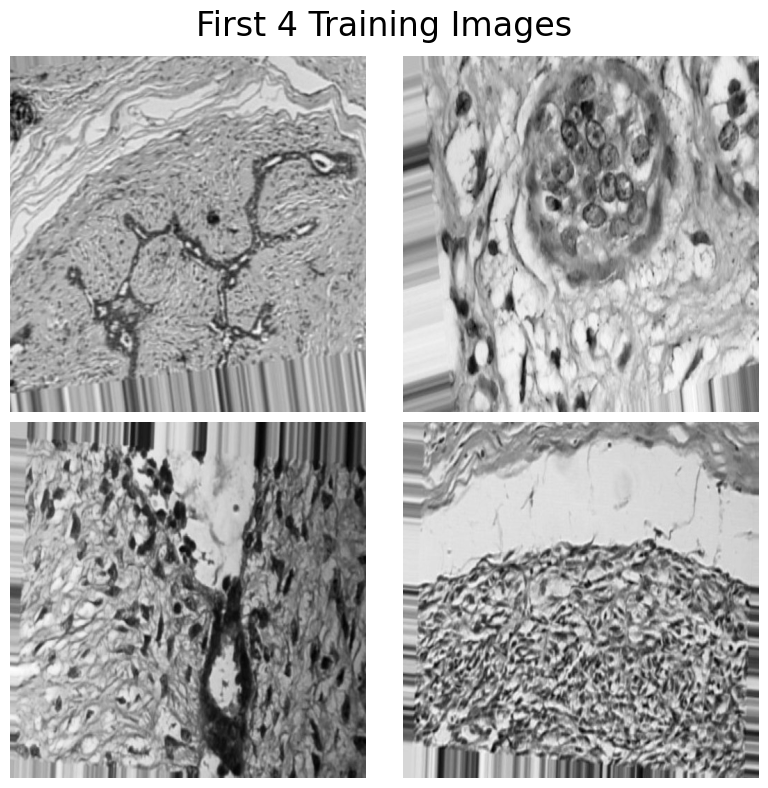

In [262]:
def plot_images(XX, N, title):
    fig, ax = plt.subplots(N, N, figsize=(8, 8))
    
    for i in range(N):
        for j in range(N):
            # Index the correct image from XX and plot it
            idx = N * i + j  # Calculate the correct index for the image
            if idx < XX.shape[0]:  # Check to make sure the index is within bounds
                ax[i, j].imshow(XX[idx], cmap="gray")  # Plot the image
            ax[i, j].axis("off")  # Turn off axis labels

        fig.suptitle(title, fontsize=24)
        plt.tight_layout()


plot_images(traindata_imgs, 2, "First 4 Training Images" )

In [263]:
# Function to plot images
def plot_imgs(XX, N, title):
    fig, axes = plt.subplots(N, N, figsize=(8, 8))
    
    for i in range(N):
        for j in range(N):
            ax = axes[i, j]
            ax.imshow(XX[N*i+j], cmap="Greys")  # Plot each image in grayscale
            ax.axis("off")
    
    fig.suptitle(title, fontsize=24)
    plt.tight_layout()
    plt.show()

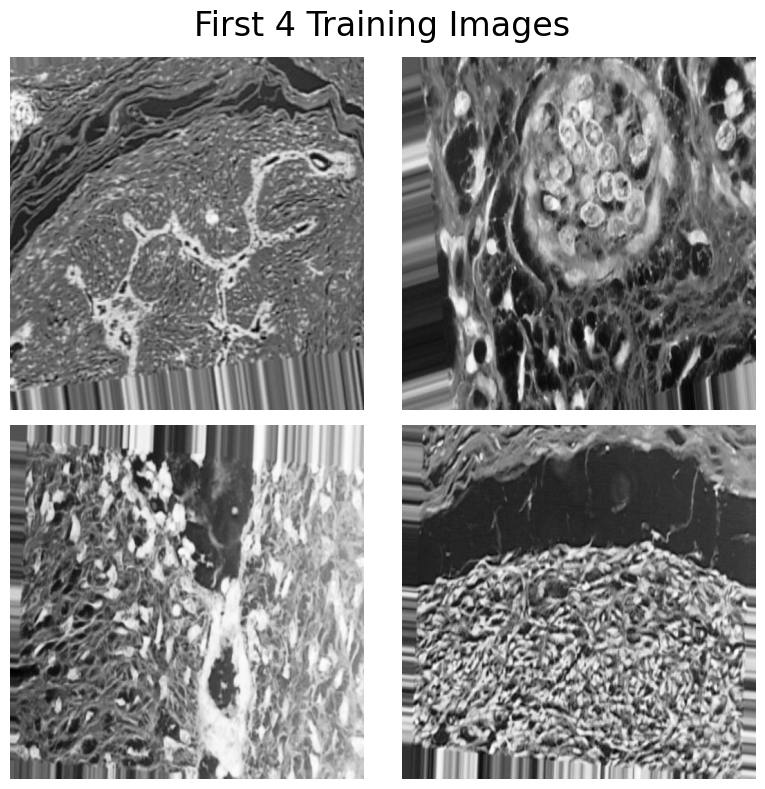

In [264]:
plot_imgs(traindata_imgs, 2, "First 4 Training Images" )

## Apply PCA

In [265]:
Xtrain1 = Xtrain.T
Xtest1 = Xtest.T

print(Xtrain1.shape)
print(Xtest1.shape)

(262144, 600)
(262144, 150)


In [279]:
# apply PCA to Xtrain
pca = PCA()
Xtrain_pca = pca.fit_transform(Xtrain1)

print("Shape of Xtrain_pca:", Xtrain_pca.shape)

modes = pca.components_


Shape of Xtrain_pca: (262144, 600)


In [280]:
Xtrain_pca1 = Xtrain_pca.T # correct formatting with samples by features 

print(Xtrain_pca1.shape)

(600, 262144)


In [ ]:
# features by samples is what we want for Xtrain
# samples by features is what we want for pca

In [ ]:
modes.shape # not right

(600, 600)

In [ ]:
# we want the possibility of 262144 modes, the columns of Xtrain_pca1
# OR the rows of Xtrain_pca

In [282]:
#singular values - variances in each direction 
sing = pca.singular_values_

#find the full Frobenius norm (energy) - using all PCA modes
fullnorm = np.sum(sing**2)
print(fullnorm)

253285124999.6476


85.07912450281789
347


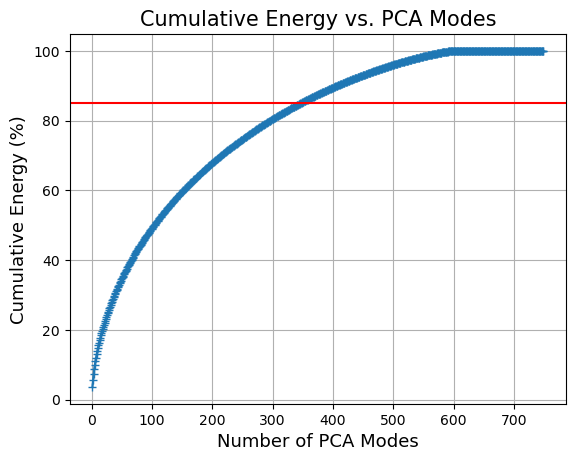

In [283]:
# PCA for different numbers of PC modes

energies = []

for j in np.arange(1,750):
    s = sing[:j]
    #norm = np.sqrt(np.sum(s**2))
    norm = np.sum(s**2)
    energy = (norm/fullnorm) * 100
    energies.append(energy)

counter = 0
for i in energies:
    counter += 1
    if i >= 85:
        print(i)
        print(counter)
        break

# plot the cumulative energy as a function of number of PCA spatial modes
plt.plot(np.arange(1,750), energies, marker='+')
plt.xlabel('Number of PCA Modes', fontsize=13)
plt.ylabel('Cumulative Energy (%)', fontsize=13)
plt.title('Cumulative Energy vs. PCA Modes', fontsize=15)
plt.grid(True)

plt.axhline(y=85, color='r')


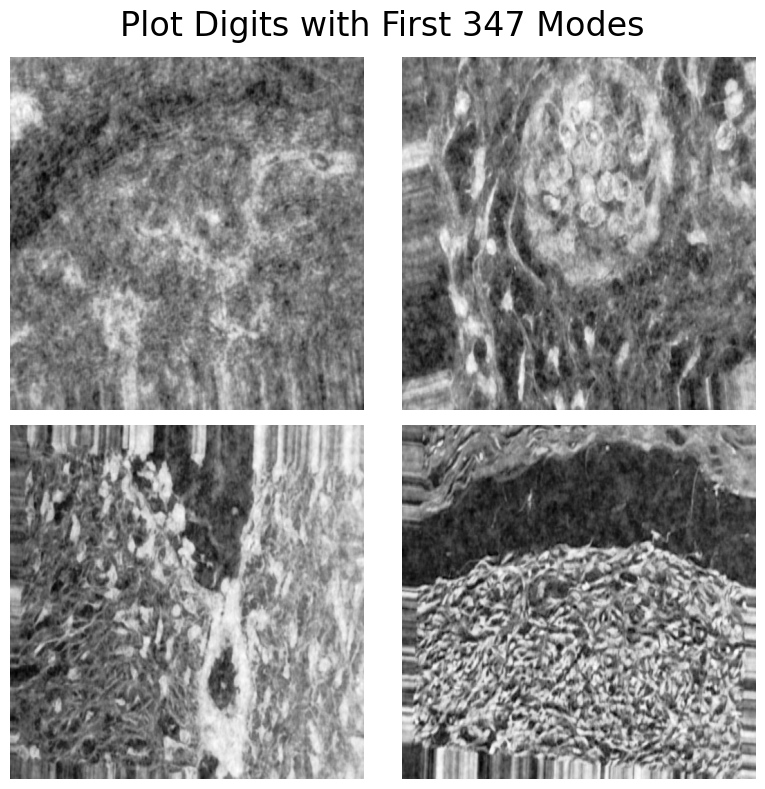

In [271]:
pca_347 = PCA(n_components=347)  
Xtrain_pca_347 = pca_347.fit_transform(Xtrain.T)

iXtrain_347 = pca_347.inverse_transform(Xtrain_pca_347)

iXtrain_347_reshaped = iXtrain_347.T.reshape(600, 512, 512)  # Shape (600, 512, 512)

# Function to plot images
def plot_images(XX, N, title):
    fig, axes = plt.subplots(N, N, figsize=(8, 8))
    
    for i in range(N):
        for j in range(N):
            ax = axes[i, j]
            ax.imshow(XX[N*i+j], cmap="Greys")  # Plot each image in grayscale
            ax.axis("off")
    
    fig.suptitle(title, fontsize=24)
    plt.tight_layout()
    plt.show()

# Plot the first 4 reconstructed images
plot_imgs(iXtrain_347_reshaped, 2, 'Plot Digits with First 347 Modes')


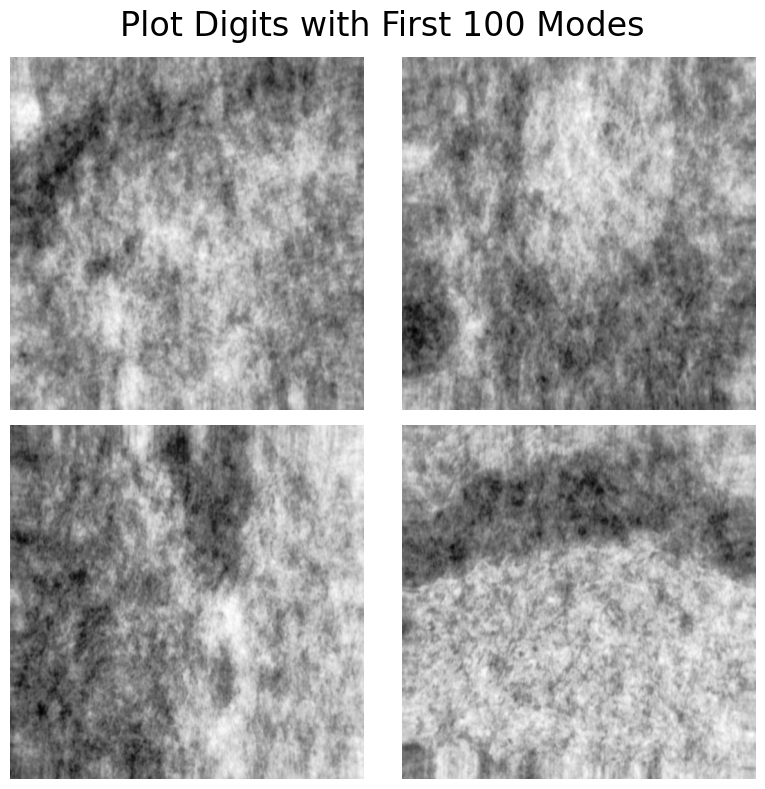

In [273]:
pca_100 = PCA(n_components=100)  
Xtrain_pca_100 = pca_100.fit_transform(Xtrain.T)

iXtrain_100 = pca_100.inverse_transform(Xtrain_pca_100)

iXtrain_100_reshaped = iXtrain_100.T.reshape(600, 512, 512)  

# Plot the first 4 reconstructed images
plot_imgs(iXtrain_100_reshaped, 2, 'Plot Digits with First 100 Modes')


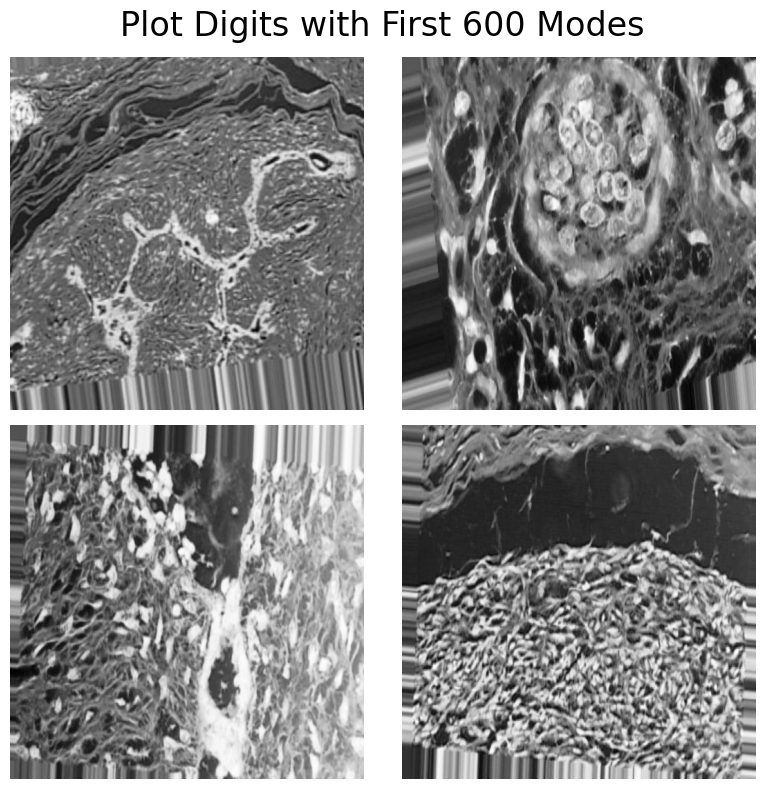

In [344]:
pca_600 = PCA(n_components=600)  
Xtrain_pca_600 = pca_600.fit_transform(Xtrain.T)

iXtrain_600 = pca_600.inverse_transform(Xtrain_pca_600)

iXtrain_600_reshaped = iXtrain_600.T.reshape(600, 512, 512)  

# Plot the first 4 reconstructed images
plot_imgs(iXtrain_600_reshaped, 2, 'Plot Digits with First 600 Modes')

## Start classifying

In [275]:
ytrainlabels = np.concatenate((np.zeros(300), np.ones(300)))

ytestlabels = np.concatenate((np.zeros(75), np.ones(75)))

### Checking PCA

In [327]:
# Checking the shape of data before PCA
print("Shape of original Xtrain1:", Xtrain1.shape)  # Should be (262144, 600)
print("Shape of ytrain:", ytrainlabels.shape)  # Should be (600,)

# Apply PCA and check shape
pca_full = PCA()
Xtrain_pca_full = pca_full.fit_transform(Xtrain1.T)  # PCA should reduce it to (600, 347)
print("Shape of PCA-transformed Xtrain:", Xtrain_pca_full.shape)

Shape of original Xtrain1: (262144, 600)
Shape of ytrain: (600,)
Shape of PCA-transformed Xtrain: (600, 600)


In [328]:
#singular values - variances in each direction 
sing_full = pca_full.singular_values_

#find the full Frobenius norm (energy) - using all PCA modes
fullnorm1 = np.sum(sing_full**2)
print(fullnorm1)

301234292381.72


85.07770087688257
317


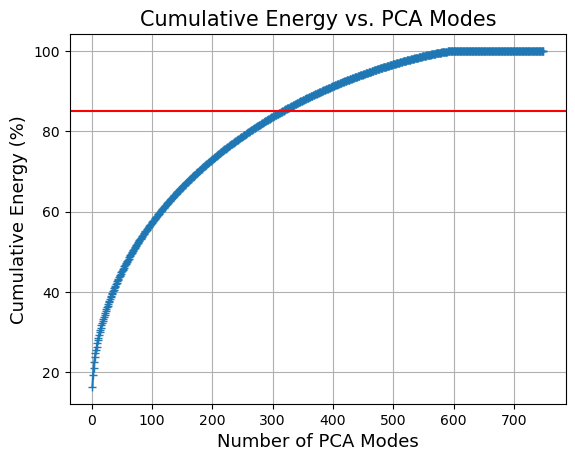

In [329]:
# PCA for different numbers of PC modes

energies = []

for j in np.arange(1,750):
    s = sing_full[:j]
    norm = np.sum(s**2)
    energy = (norm/fullnorm1) * 100
    energies.append(energy)

counter = 0
for i in energies:
    counter += 1
    if i >= 85:
        print(i)
        print(counter)
        break

# plot the cumulative energy as a function of number of PCA spatial modes
plt.plot(np.arange(1,750), energies, marker='+')
plt.xlabel('Number of PCA Modes', fontsize=13)
plt.ylabel('Cumulative Energy (%)', fontsize=13)
plt.title('Cumulative Energy vs. PCA Modes', fontsize=15)
plt.grid(True)

plt.axhline(y=85, color='r')


In [330]:
Xtrain_pca_347.shape

(262144, 347)

## Ridge

In [297]:
# Checking the shape of data before PCA
print("Shape of original Xtrain1:", Xtrain1.shape)  # Should be (262144, 600)
print("Shape of ytrain:", ytrainlabels.shape)  # Should be (600,)

# Apply PCA and check shape
pca347 = PCA(n_components=347)
Xtrain_pca347 = pca347.fit_transform(Xtrain1.T)  # PCA should reduce it to (600, 347)
print("Shape of PCA-transformed Xtrain:", Xtrain_pca347.shape)


Shape of original Xtrain1: (262144, 600)
Shape of ytrain: (600,)
Shape of PCA-transformed Xtrain: (600, 347)


In [298]:
Xtest_pca347 = pca347.transform(Xtest1.T)

print(Xtest_pca347.shape)

(150, 347)


In [289]:
Xtest.shape

(150, 262144)

In [299]:
RidgeCL = RidgeClassifierCV()
RidgeCL.fit(Xtrain_pca347, ytrainlabels)

RidgeClassifierCV()

In [300]:
# estimate accuracy for Training and Testing

print("Training Score: {}".format(RidgeCL.score(Xtrain_pca347, ytrainlabels)))
print("Testing Score: {}".format(RidgeCL.score(Xtest_pca347, ytestlabels)))

Training Score: 0.9083333333333333
Testing Score: 0.5666666666666667


In [301]:
#using cross validation

tr_scores_ridge = cross_val_score(RidgeCL, Xtrain_pca347, ytrainlabels, cv=5)
print("{} training accuracy with a standard deviation of {}".format(tr_scores_ridge.mean(), tr_scores_ridge.std()))

0.585 training accuracy with a standard deviation of 0.052546275901448156


#### Confusion matrix

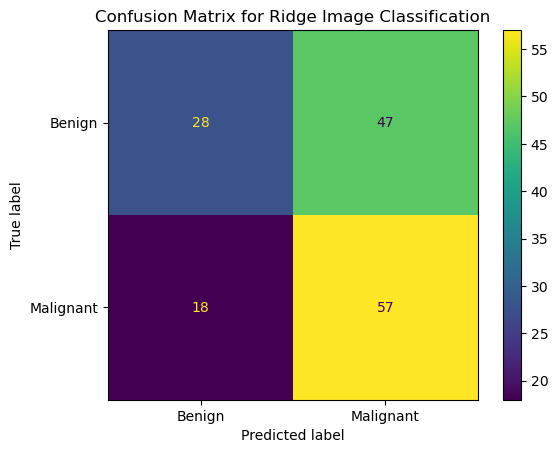

In [ ]:
y_pred = RidgeCL.predict(Xtest_pca347)


fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(ytestlabels, y_pred, ax=ax)
ax.xaxis.set_ticklabels(['Benign', 'Malignant'])
ax.yaxis.set_ticklabels(['Benign', 'Malignant'])
_ = ax.set_title(
    f"Confusion Matrix for Ridge Image Classification"
)

## KNN

In [360]:
KNNCL = KNeighborsClassifier(n_neighbors=12)
KNNCL.fit(Xtrain_pca347, ytrainlabels)

KNeighborsClassifier(n_neighbors=12)

In [361]:
# estimate accuracy for Training and Testing - for KNN 12 neighbors  

print("Training Score: {}".format(KNNCL.score(Xtrain_pca347, ytrainlabels)))
print("Testing Score: {}".format(KNNCL.score(Xtest_pca347, ytestlabels)))

knn_train_score = cross_val_score(KNNCL, Xtrain_pca347, ytrainlabels, cv=5)
print("{} training accuracy with a standard deviation of {}".format(knn_train_score.mean(), knn_train_score.std()))


Training Score: 0.7083333333333334
Testing Score: 0.4866666666666667
0.6533333333333333 training accuracy with a standard deviation of 0.02211083193570265


In [314]:
k_values = [i for i in range (1,50)]
scores = []

for k in k_values:
    KNNCLk = KNeighborsClassifier(n_neighbors=k)
    scorescv = cross_val_score(KNNCLk, Xtrain_pca347, ytrainlabels, cv=5)
    print("{} accuracy with a standard deviation of {}".format(scorescv.mean(), scorescv.std()))
    scores.append(scorescv.mean())

# print("{} accuracy with a standard deviation of {}".format(scores.mean(), scores.std()))

0.5366666666666667 accuracy with a standard deviation of 0.0648930744464393
0.505 accuracy with a standard deviation of 0.025055493963954862
0.5800000000000001 accuracy with a standard deviation of 0.03188521078284832
0.5666666666666667 accuracy with a standard deviation of 0.007453559924999273
0.615 accuracy with a standard deviation of 0.028087165910587845
0.6116666666666667 accuracy with a standard deviation of 0.031001792062897125
0.6133333333333334 accuracy with a standard deviation of 0.02333333333333336
0.6333333333333333 accuracy with a standard deviation of 0.028382310609877337
0.63 accuracy with a standard deviation of 0.01943650631615101
0.6433333333333333 accuracy with a standard deviation of 0.02494438257849296
0.625 accuracy with a standard deviation of 0.02527625148017184
0.6533333333333333 accuracy with a standard deviation of 0.02211083193570265
0.625 accuracy with a standard deviation of 0.022973414586817033
0.625 accuracy with a standard deviation of 0.01666666666666

0.6533333333333333
12


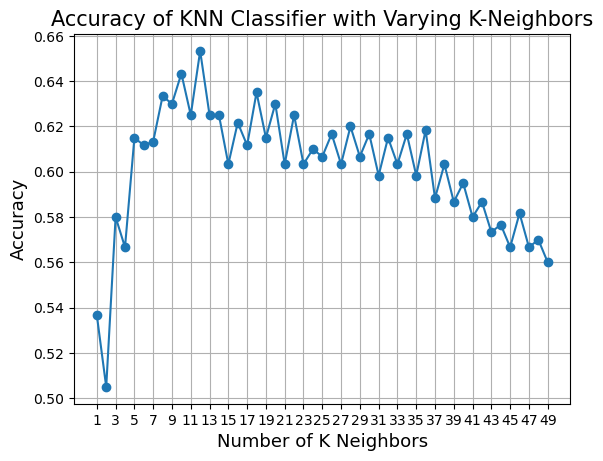

In [315]:
k_peak = np.argmax(scores)
optimal_knn = k_peak + 1

print(scores[k_peak])
print(optimal_knn)

plt.plot(k_values, scores, marker = "o")
plt.xlabel('Number of K Neighbors', fontsize=13)
plt.xticks(range(1, 50, 2))
plt.ylabel('Accuracy', fontsize=13)
plt.title('Accuracy of KNN Classifier with Varying K-Neighbors', fontsize=15)
plt.grid(True)


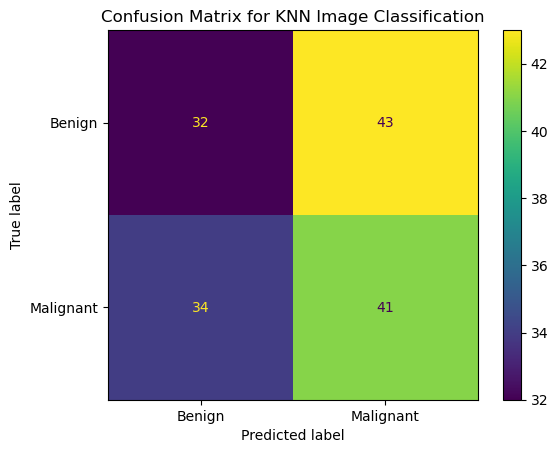

In [362]:
knn_pred = KNNCL.predict(Xtest_pca347)


fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(ytestlabels, knn_pred, ax=ax)
ax.xaxis.set_ticklabels(['Benign', 'Malignant'])
ax.yaxis.set_ticklabels(['Benign', 'Malignant'])
_ = ax.set_title(
    f"Confusion Matrix for KNN Image Classification"
)

## LDA

In [332]:
LDACL = LinearDiscriminantAnalysis()
LDACL.fit(Xtrain_pca347, ytrainlabels)


LinearDiscriminantAnalysis()

In [333]:
# estimate accuracy for Training and Testing

print("Training Score: {}".format(LDACL.score(Xtrain_pca347, ytrainlabels)))
print("Testing Score: {}".format(LDACL.score(Xtest_pca347, ytestlabels)))

lda_train_score = cross_val_score(LDACL, Xtrain_pca347, ytrainlabels, cv=5)
print("{} training accuracy with a standard deviation of {}".format(lda_train_score.mean(), lda_train_score.std()))

Training Score: 0.9083333333333333
Testing Score: 0.5666666666666667
0.585 training accuracy with a standard deviation of 0.052546275901448156


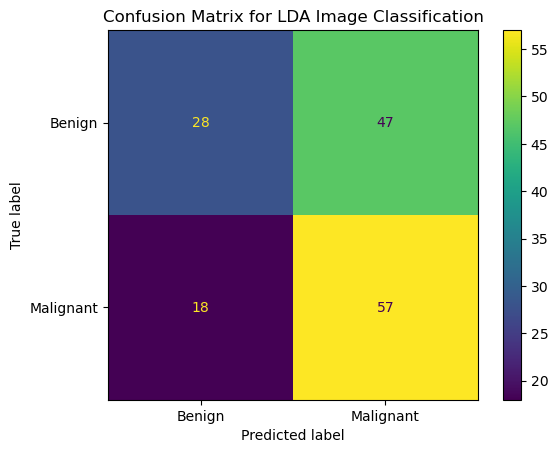

In [334]:
lda_pred = LDACL.predict(Xtest_pca347)

fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(ytestlabels, lda_pred, ax=ax)
ax.xaxis.set_ticklabels(['Benign', 'Malignant'])
ax.yaxis.set_ticklabels(['Benign', 'Malignant'])
_ = ax.set_title(
    f"Confusion Matrix for LDA Image Classification"
)

## SVM

In [337]:
SVMCL = svm.SVC()
SVMCL.fit(Xtrain_pca347, ytrainlabels)

SVC()

In [338]:
# estimate accuracy for Training and Testing

print("Training Score: {}".format(SVMCL.score(Xtrain_pca347, ytrainlabels)))
print("Testing Score: {}".format(SVMCL.score(Xtest_pca347, ytestlabels)))

svm_train_score = cross_val_score(SVMCL, Xtrain_pca347, ytrainlabels, cv=5)
print("{} training accuracy with a standard deviation of {}".format(svm_train_score.mean(), svm_train_score.std()))

Training Score: 0.9383333333333334
Testing Score: 0.6133333333333333
0.76 training accuracy with a standard deviation of 0.039581140290126396


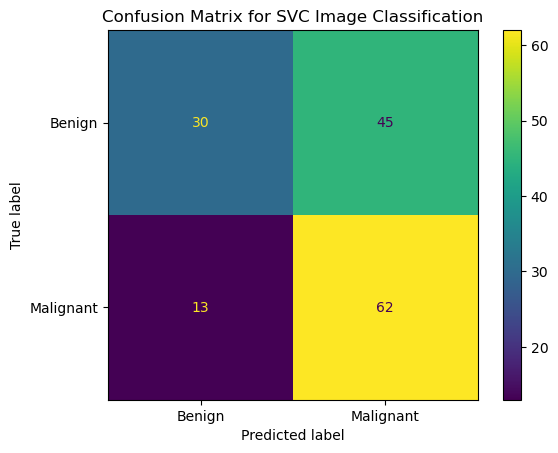

In [339]:
svm_pred = SVMCL.predict(Xtest_pca347)

fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(ytestlabels, svm_pred, ax=ax)
ax.xaxis.set_ticklabels(['Benign', 'Malignant'])
ax.yaxis.set_ticklabels(['Benign', 'Malignant'])
_ = ax.set_title(
    f"Confusion Matrix for {SVMCL.__class__.__name__} Image Classification"
)

## Try to solve overfitting with more/less PCA modes

In [340]:
# check shape of data before PCA
print("Shape of original Xtrain1:", Xtrain1.shape)  # Should be (262144, 600)
print("Shape of ytrain:", ytrainlabels.shape)  # Should be (600,)

# apply PCA and check shape
pca100 = PCA(n_components=100)
Xtrain_pca100 = pca100.fit_transform(Xtrain1.T)  # PCA should reduce it to (600, 347)
print("Shape of PCA-transformed Xtrain:", Xtrain_pca100.shape)

Shape of original Xtrain1: (262144, 600)
Shape of ytrain: (600,)
Shape of PCA-transformed Xtrain: (600, 100)


In [342]:
Xtest_pca100 = pca100.transform(Xtest1.T)

print(Xtest_pca100.shape)

(150, 100)


In [341]:
SVMCLo1 = svm.SVC()
SVMCLo1.fit(Xtrain_pca100, ytrainlabels)

SVC()

In [343]:
# estimate accuracy for Training and Testing

print("Training Score: {}".format(SVMCLo1.score(Xtrain_pca100, ytrainlabels)))
print("Testing Score: {}".format(SVMCLo1.score(Xtest_pca100, ytestlabels)))

svm_train_score100 = cross_val_score(SVMCLo1, Xtrain_pca100, ytrainlabels, cv=5)
print("{} training accuracy with a standard deviation of {}".format(svm_train_score100.mean(), svm_train_score100.std()))

Training Score: 0.905
Testing Score: 0.7266666666666667
0.7233333333333334 training accuracy with a standard deviation of 0.04755114205895703


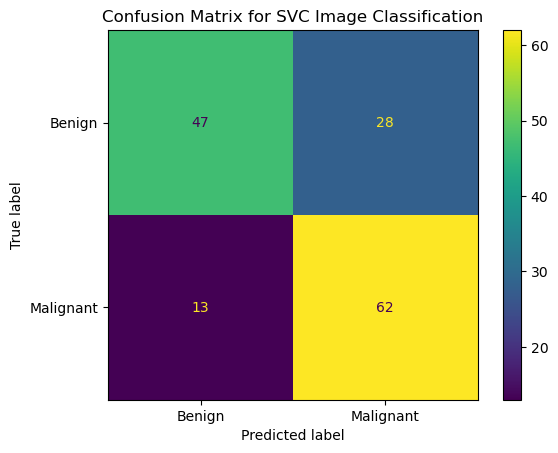

In [366]:
svm_pred100 = SVMCLo1.predict(Xtest_pca100)

fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(ytestlabels, svm_pred100, ax=ax)
ax.xaxis.set_ticklabels(['Benign', 'Malignant'])
ax.yaxis.set_ticklabels(['Benign', 'Malignant'])
_ = ax.set_title(
    f"Confusion Matrix for {SVMCLo1.__class__.__name__} Image Classification"
)

In [345]:
# try 50 modes
# 
# # apply PCA and check shape
pca50 = PCA(n_components=50)
Xtrain_pca50 = pca50.fit_transform(Xtrain1.T)  # PCA should reduce it to (600, 347)
print("Shape of PCA-transformed Xtrain:", Xtrain_pca50.shape)

Shape of PCA-transformed Xtrain: (600, 50)


In [347]:
Xtest_pca50 = pca50.transform(Xtest1.T)

print(Xtest_pca50.shape)

(150, 50)


In [346]:
SVMCLo2 = svm.SVC()
SVMCLo2.fit(Xtrain_pca50, ytrainlabels)

SVC()

In [348]:
# estimate accuracy for Training and Testing

print("Training Score: {}".format(SVMCLo2.score(Xtrain_pca50, ytrainlabels)))
print("Testing Score: {}".format(SVMCLo2.score(Xtest_pca50, ytestlabels)))

svm_train_score50 = cross_val_score(SVMCLo2, Xtrain_pca50, ytrainlabels, cv=5)
print("{} training accuracy with a standard deviation of {}".format(svm_train_score50.mean(), svm_train_score50.std()))

Training Score: 0.8716666666666667
Testing Score: 0.7333333333333333
0.73 training accuracy with a standard deviation of 0.04490731195102492


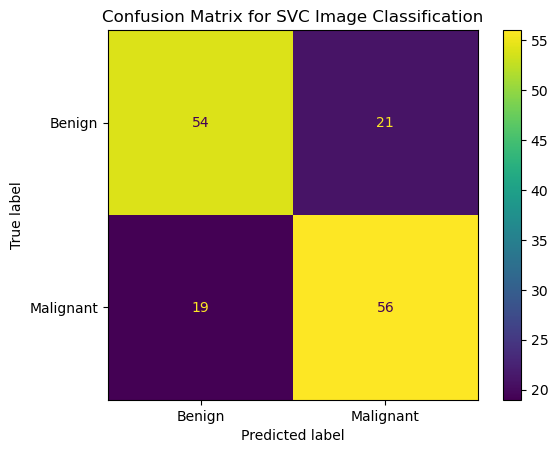

In [367]:
svm_pred50 = SVMCLo2.predict(Xtest_pca50)

fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(ytestlabels, svm_pred50, ax=ax)
ax.xaxis.set_ticklabels(['Benign', 'Malignant'])
ax.yaxis.set_ticklabels(['Benign', 'Malignant'])
_ = ax.set_title(
    f"Confusion Matrix for {SVMCLo2.__class__.__name__} Image Classification"
)

## See what optimal number of modes for SVM train/test accuracy and train CV would be

In [363]:
train_svm_accs = []
test_svm_accs = []
cv_means_svm = []

for j in range(1,301,15):
    pca_j = PCA(n_components=j)
    Xtrain_pca_j = pca_j.fit_transform(Xtrain1.T)  # PCA should reduce it to (600, j)
    print("Shape of PCA-transformed Xtrain:", Xtrain_pca_j.shape)

    Xtest_pca_j = pca_j.transform(Xtest1.T)

    SVMCLoj = svm.SVC()
    SVMCLoj.fit(Xtrain_pca_j, ytrainlabels)

    # estimate accuracy for Training and Testing

    train_score_svm_j = SVMCLoj.score(Xtrain_pca_j, ytrainlabels)
    test_score_svm_j = SVMCLoj.score(Xtest_pca_j, ytestlabels)

    print("Training Score: {}".format(SVMCLoj.score(Xtrain_pca_j, ytrainlabels)))
    print("Testing Score: {}".format(SVMCLoj.score(Xtest_pca_j, ytestlabels)))

    train_svm_accs.append(train_score_svm_j)
    test_svm_accs.append(test_score_svm_j)

    svm_train_score_j = cross_val_score(SVMCLoj, Xtrain_pca_j, ytrainlabels, cv=5)
    print("{} training accuracy with a standard deviation of {}".format(svm_train_score_j.mean(), svm_train_score_j.std()))

    cv_means_svm.append(np.mean(svm_train_score_j))



Shape of PCA-transformed Xtrain: (600, 1)
Training Score: 0.675
Testing Score: 0.7
0.675 training accuracy with a standard deviation of 0.04859126579037748
Shape of PCA-transformed Xtrain: (600, 16)
Training Score: 0.8116666666666666
Testing Score: 0.7066666666666667
0.7166666666666667 training accuracy with a standard deviation of 0.04048319267163707
Shape of PCA-transformed Xtrain: (600, 31)
Training Score: 0.8433333333333334
Testing Score: 0.7333333333333333
0.7183333333333334 training accuracy with a standard deviation of 0.032231799343022866
Shape of PCA-transformed Xtrain: (600, 46)
Training Score: 0.87
Testing Score: 0.7466666666666667
0.7116666666666667 training accuracy with a standard deviation of 0.03674234614174766
Shape of PCA-transformed Xtrain: (600, 61)
Training Score: 0.8716666666666667
Testing Score: 0.7333333333333333
0.7266666666666667 training accuracy with a standard deviation of 0.052546275901448156
Shape of PCA-transformed Xtrain: (600, 76)
Training Score: 0.885

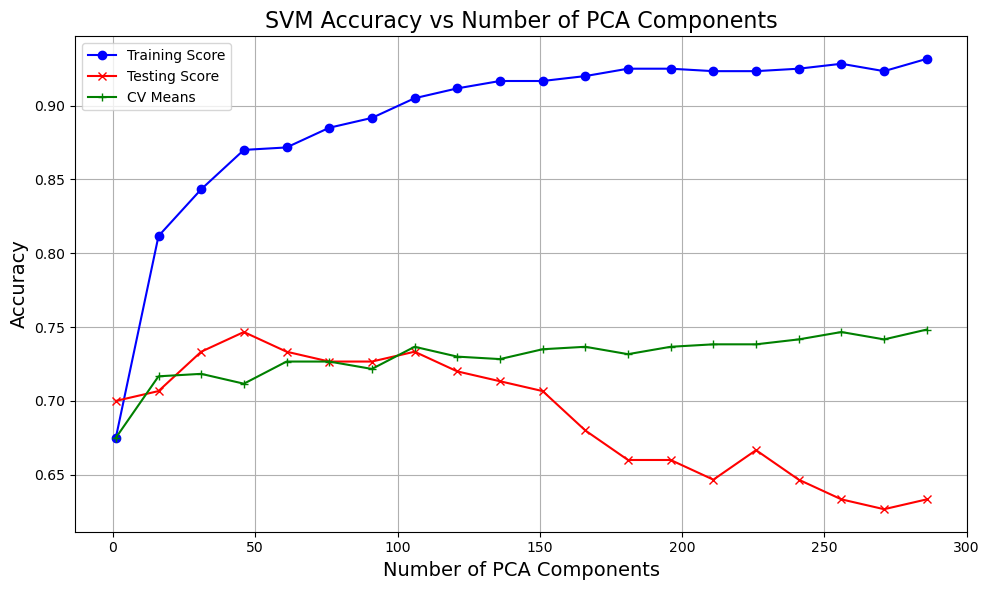

In [364]:
plt.figure(figsize=(10, 6))

# Plot training scores
plt.plot(range(1, 301,15), train_svm_accs, label='Training Score', color='blue', linestyle='-', marker='o')

# Plot testing scores
plt.plot(range(1, 301,15), test_svm_accs, label='Testing Score', color='red', linestyle='-', marker='x')

plt.plot(range(1, 301,15), cv_means_svm, label='CV Means', color='green', linestyle='-', marker='+')


# Labels and title
plt.xlabel('Number of PCA Components', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('SVM Accuracy vs Number of PCA Components', fontsize=16)
plt.legend(loc='best')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()